# A simple forward-time simulator

We will create a simple forward-time simulator using python and [tskit](https://tskit.dev/). This will be a "diploid" simulator, in which a single individual contains 2 genomes. Note the important distinction between an *individual* and the *genomes* it contains. Strictly, individuals are not necessary for representing genetic genealogies (it's the genomes which are important) but grouping pairs of genomes within an individual helps when constructing realistic forward simulations. From the `tskit` point of view, the individual corresponds to an entry in the [individual table](https://tskit.dev/tskit/docs/stable/data-model.html#sec-individual-table-definition), and its two genomes correspond to two separate entries in the [node table](https://tskit.dev/tskit/docs/stable/data-model.html#node-table). As our simulation progresses, we add entries to the relevant `tskit` tables, and then,
at the end, turn those tables into an immutable [tree sequence](https://tskit.dev/tutorials/what_is.html).

<div class="alert alert-block alert-info">
    <b>Note:</b> 
Individuals and genomes (nodes) are numbered independently in `tskit`. Each individual will have an ID, ranging from zero to the total number of individuals in the tree sequence. Its two genomes will have separate IDs, ranging from zero to the total number of nodes in the tree sequence. Some care is needed when using the IDs of an individual or the IDs of its genomes, because these IDs are not permanent: they can change when individuals or genomes are removed from the tree sequence, e.g. by simplification.
</div>

First, we'll import the necessary libraries and define some general parameters. The [numpy](https://numpy.org/doc/stable/) library will be used to produce random numbers.

In [1]:
import tskit
import numpy as np

random_seed = 123
random = np.random.default_rng(random_seed)  # A random number generator for general use

diploid_population_size = 6
sequence_length = 50_000  # 50 Kb

We'll start by simulating a small region of a larger genome (e.g. a "gene", or a portion of a gene).
We will assume the region is small enough that there is no recombination. The first building block
of this simulation will be to define how one of the child's genomes in our simulation, say the
maternal one, is created from the two genomes that were present in the individual mother. If there is no recombination, we can simply pick one of the mother's genomes at random. We save the inheritance paths in the [edge table](https://tskit.dev/tskit/docs/stable/data-model.html#edge-table).

In [2]:
focal_region = [20_000, 21_000]
def add_inheritance_paths(tables, parent_genomes, child_genome):
    "Add inheritance paths from a randomly chosen parent genome to the child genome"
    left, right = focal_region  # only define inheritance in this focal region
    inherit_from = random.integers(2)  # randomly chose 0 or 1
    tables.edges.add_row(left, right, parent_genomes[inherit_from], child_genome)

# Should we test this routine somehow?

We can incorporate the `add_inheritance_paths` function into a larger function which generates a new population of individuals and their genomes. First we create a new child individual and two genomes, adding them to the [individual table](https://tskit.dev/tskit/docs/stable/data-model.html#sec-individual-table-definition) and the [node table](https://tskit.dev/tskit/docs/stable/data-model.html#node-table) repsectively. Then we select parents for the two genomes and add the inheritance paths. 

For convenience, we track the population as a Python dictionary, mapping the individual ID to the IDs of its two genomes. This allows us to chose an individual at random and access the IDs of its two genomes.

<div class="alert alert-block alert-info">
    <b>Note:</b> 
For simplicity, we assume any parent can be a mother or a father (i.e. these is a hermaphrodite species). We also allow the same parent to be chosed as a mother and as a father (i.e. "selfing" is allowed), which gives simpler theoretical results. However, this is easy to change.
</div>

In [3]:
def new_population(tables, time, prev_population=None) -> dict:
    """
    Returns a Python dict of length `diploid_population_size` representing a population,
    optionally derived from a prev_population of the same form. Populations look like
    {individual_ID: (maternal_genome_ID, paternal_genome_ID), ...}
    """
    if prev_population is not None:
        prev_individuals = np.array([i for i in prev_population])  # Efficient array

    population = {}  # children will be added to this population
    for _ in range(diploid_population_size):
        # make a new child individual by adding a row to the individuals table
        # and two rows to the nodes table (maternal and paternal genomes)
        i = tables.individuals.add_row()
        population[i] = (
            tables.nodes.add_row(tskit.NODE_IS_SAMPLE, time, individual=i),
            tables.nodes.add_row(tskit.NODE_IS_SAMPLE, time, individual=i),
        )
        if prev_population:
            # pick two parent IDs at random (`replace=True` means selfing is allowed)
            mother_and_father = random.choice(prev_individuals, 2, replace=True)
            # loop over both child genomes: 1st inherits from mother, 2nd from father
            for child_genome, parent_individual in zip(population[i], mother_and_father):
                parent_genomes = prev_population[parent_individual]
                add_inheritance_paths(tables, parent_genomes, child_genome)
    return population

A forward-in-time simulator simply involves repeatedly running the `new_population()` routine, replacing the old population with the new one. For efficiency reasons, `tskit` has strict requirements for the order of edges in the edge table, so we need to [sort](https://tskit.dev/tskit/docs/stable/python-api.html?highlight=sort#tskit.TableCollection.sort) the tables before we output the final; tree sequence.

In [4]:
def simple_diploid_sim(generations) -> tskit.TreeSequence:
    tables = tskit.TableCollection(sequence_length)
    tables.time_units = "generations"  # optional, but helpful when plotting
    generations_ago = generations - 1  # start with the oldest generation ago

    population = new_population(tables, generations_ago)  # init
    # Run the simulation
    while generations_ago > 0:
        generations_ago = generations_ago - 1
        population = new_population(tables, generations_ago, population)

    # Sort the tables, e.g. to put edges in the required order
    tables.sort()
    return tables.tree_sequence()


### Now run a simulation!
ts = simple_diploid_sim(generations=10)

We can draw out this tree sequence: by convention we put the most recent generation at the bottom of the plot (i.e. peversely, each "tree" has leaves towards the bottom, and roots at the top). As there is no recombination, our simulation has generated a single [tree](https://tskit.dev/tskit/docs/stable/glossary.html#definitions) spanning the focal region.

Remember that we started the simulation with a set of unrelated individuals. So this "tree" may look a little strange; the tips of the tree will not trace a path upwards to a single common ancestor. In other words, this tree has [multiple roots](https://tskit.dev/tskit/docs/stable/data-model.html#roots).

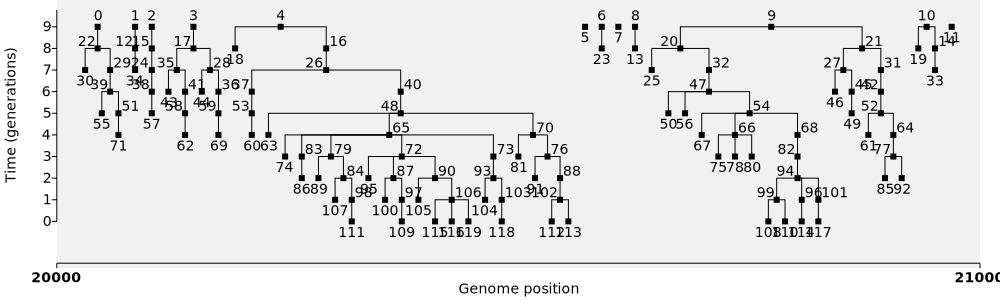

In [5]:
ts.draw_svg(size=(1000, 300), y_axis=True)

This tree shows the relationships between *all* the genomes at this position, including the genomes of individuals in previous generations. Many of these "historical genomes" are not ancestors of the 12 genomes from 6 individuals that make up the current-day population, at time 0.

We can remove the "extinct" lineages by [simplifying](https://tskit.dev/tutorials/simplification.html), retaining only those lineages relevant to the genomes in the current generation:

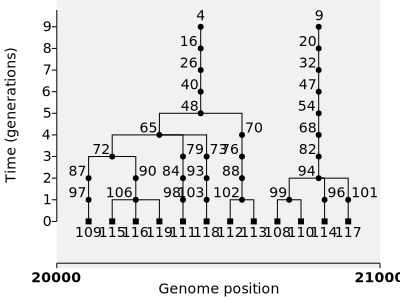

In [6]:
current_day_genomes = ts.samples(time=0)
simplified_ts = ts.simplify(current_day_genomes, keep_unary=True, filter_nodes=False)
simplified_ts.draw_svg(size=(400, 300), y_axis=True)

Because we specified `filter_nodes=False`, our new tree sequence has retained all nodes after simplification, although many are no longer part of the genealogy. Removing these redundant nodes will shrink the size of our tree sequence, but care needs to be taken as the node IDs will change. In particular, the list of nodes passed to `simplify` (here, the current-day genomes) will become the first nodes in the table, and hence be numbered from 0..11.

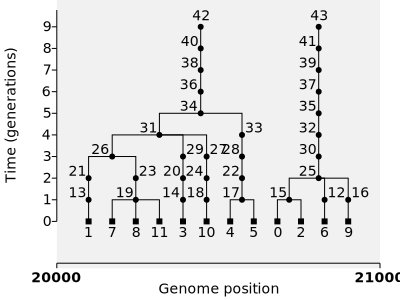

In [7]:
simplified_ts = ts.simplify(current_day_genomes, keep_unary=True)
simplified_ts.draw_svg(size=(400, 300), y_axis=True)

The `keep_unary=True` parameter meant that we kept intermediate ("unary") nodes, even those that do not not represent branch-points in the tree. Often these are also unneeded, and the default is to remove those too:

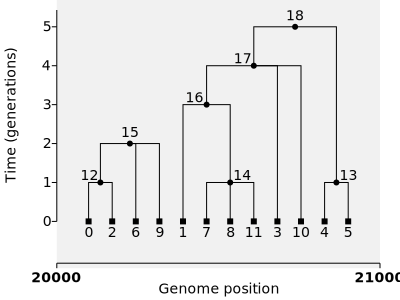

In [8]:
simplified_ts = ts.simplify(ts.samples(time=0))
simplified_ts.draw_svg(size=(400, 300), y_axis=True)

Running the foward simulation for more generations will lead to a tree sequence in which we can find the common ancestor of all the current day genomes:

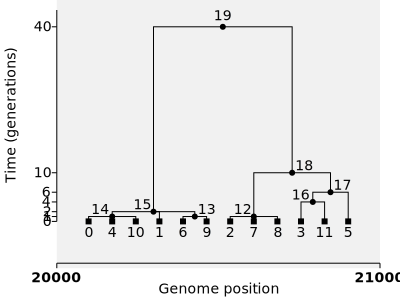

In [9]:
ts = simple_diploid_sim(generations=50)
simplified_ts = ts.simplify(ts.samples(time=0))
simplified_ts.draw_svg(size=(400, 300), y_axis=True)

## Recombination

It is relatively easy to allow recombination. All we need to do is to redefine the `add_inheritance_paths()` function, so that the child inherits a mosaic of the two genomes that it inherits from a parent.

The redefined function selects a set of "breakpoints" along the genome (in continuous space, although this can be alter to discrete coordinates). It then allocates an edge from zero to breakpoint 1 that points to one parent genome, another edge from breakpoint 1 to breakpoint 2 that points to the other parent genome, another edge from breakpoint 2 to breakpoint 3 that points back to the original parent genome, and so forth, up to the end of the sequence. Biologically, the recombination rate usually results in a relatively small number of breakpoints per chromosome (in humans, around 1 or 2).

In [10]:
recombination_rate = 1e-6

def add_inheritance_paths(tables, parent_genomes, child_genome):
    "Add paths from parent genomes to the child genome, with crossover recombination"
    L = tables.sequence_length
    num_recombinations = random.poisson(recombination_rate * L)
    breakpoints = random.uniform(0, L, size=num_recombinations)
    breakpoints = np.concatenate(([0], np.unique(breakpoints), [L]))
    inherit_from = random.integers(2)  # starting parental genome
    # iterate over pairs of ([0, b1], [b1, b2], [b2, b3], ... [bN, L])
    for left, right in zip(breakpoints[:-1], breakpoints[1:]):
        tables.edges.add_row(
            left, right, parent_genomes[inherit_from], child_genome)
        inherit_from = 1 - inherit_from  # switch to other parent genome


# Only simulate a few generations, for testing
ts = simple_diploid_sim(generations=5)  # Now includes recombination

Recombination should lead to different trees in different genomic regions:

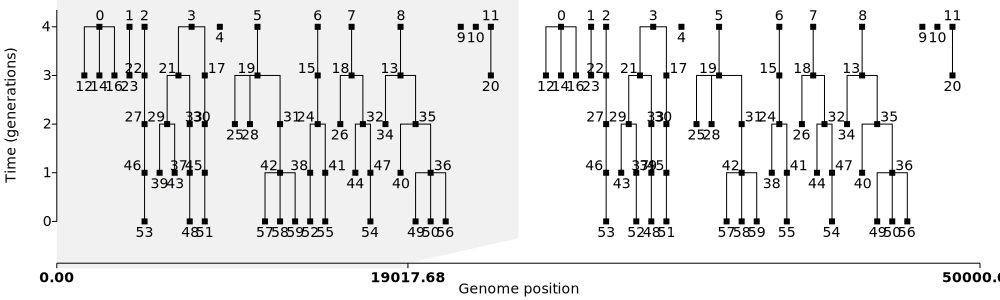

In [11]:
ts.draw_svg(size=(1000, 300), y_axis=True)

The full (unsimplified) tree sequence is rather hard to visualise, and will be even worse once we simulate more generations. However, if we simplify it, we can reduce the genealogy to something more managable, both for analysis and for visualization:

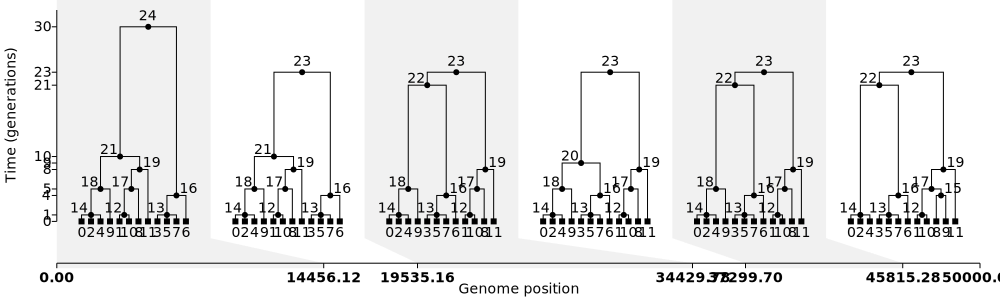

In [12]:
ts = simple_diploid_sim(generations=50)
simplified_ts = ts.simplify(ts.samples(time=0))
simplified_ts.draw_svg(size=(1000, 300), y_axis=True)

We have only simulated a relatively small population size (6 diploids). We can easily simulate a much larger population by setting the global `diploid_population_size` variable to (say) 500. The resulting simplified tree sequence will be reasonably small in terms of disk and memory storage, but will be problematic to visualise. This is where `simplify` can come in handy again: in this case, we can use it to reduce the genealogy to a handful of (hopefully representative) current-day genomes, or possibly a handful of current-day individuals (i.e. retaining both genomes from a randomly selected set of individuals:

In [13]:
diploid_population_size = 500
gens = 1000
large_ts = simple_diploid_sim(generations=gens) # May take a minute or two
print(
    f"Finished simulating {diploid_population_size} individuals",
    f"({diploid_population_size * 2} genomes)",
    f"for {gens} generations",
)

Finished simulating 500 individuals (1000 genomes) for 1000 generations


In [14]:
print(f"Full tree sequence including dead lineages: {large_ts.nbytes/1024/1024:.2f} MB")
current_day_genomes = large_ts.samples(time=0)
simplified_ts = large_ts.simplify(current_day_genomes)
print(
    f"Tree sequence of current-day individuals: {simplified_ts.nbytes/1024/1024:.2f} MB,",
    f"{simplified_ts.num_trees} trees."
)

Full tree sequence including dead lineages: 80.06 MB
Tree sequence of current-day individuals: 0.25 MB, 592 trees.


Even the simplified genealogy will consist of hundreds of trees, each with a thousand tips. One way to reduce this for plotting is to select a set of genomes from randomly chosen current-day individuals, and plot only a small region. See the [visualization tutorial](https://tskit.dev/tutorials/viz.html) for other options.

Plotting individuals with these IDs in the simplified ts: [1515 1362 1518 1520 1629 1357]
These correspond to the genomes with these IDs: [362 363 372 373 678 679 684 685 688 689 906 907]


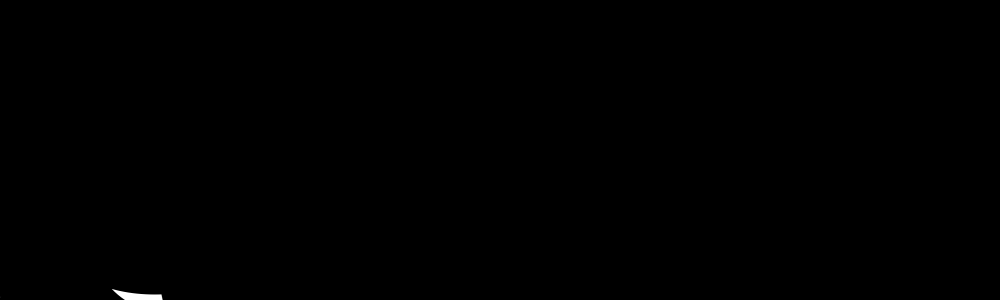

In [15]:
# Select e.g. 6 randomly chosen individuals for display purposes
# NB: understanding the code below requires some knowledge of numpy
current_day_individuals = simplified_ts.nodes_individual[simplified_ts.samples()]
use = random.choice(np.unique(current_day_individuals), 6, replace=False)  # Chose 6
print("Plotting individuals with these IDs in the simplified ts:", use)

# Find the genomes corresponding to these individuals
genomes_to_use = np.isin(simplified_ts.nodes_individual, use)
selected_genomes = np.where(genomes_to_use)[0]
print("These correspond to the genomes with these IDs:", selected_genomes)

# Keep the node IDs of the simplified_ts, to compare
representative_ts = simplified_ts.simplify(selected_genomes, filter_nodes=False)

# plot a short region of genome, using some plot tweaks
representative_ts.draw_svg(
    size=(1000, 300),
    x_lim=[10_000, 11_000],
    y_axis=True,
    time_scale="log_time",
    y_ticks = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
    style=(
        ".node > .lab {font-size: 80%}"
        ".leaf > .lab {text-anchor: start; transform: rotate(90deg) translate(6px)}"
    )
)

You can see that some of these strees still have multiple roots. In other words, 1000 generations is not long enough to capture the ancestry back to a single common ancestor. And the larger the populations, the longer the time needed to ensure that the full genealogy is captured. A powerful way to get around this problem is *recapitation*, in which we use an alternative method to fill in the "head" of the tree sequence, i.e. the genealogy relating those individuals which started the forward simulation. The `tskit` library provides easy functionality to do this using the backward-in-time `msprime` simulator:

In [16]:
# To complete - show recapitation